In [1]:
#time2 directory has POC...
#MCR50000 has good comparisons for RNN Markov and CGP.
#paper1FIX has best results
directory_path = "paper1FIX"

In [ ]:
#good luck 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import re
import seaborn as sns

scoresDirs = []

def helper(col):
    brain = col[:re.search(r'\D+', col).end()]
    brainID = col[re.search(r'\d', col).start()]
    match = match = re.search(r'\D*\d\D*(\d)', col)
    if match:
        resourceID = match.group(1)
    return brain, brainID, resourceID

def agg(frames, col):
    concatenated_scores = pd.concat([df[col] for df in frames], axis=1)
    mean_scores = concatenated_scores.mean(axis=1)
    sem_scores = concatenated_scores.sem(axis=1)
    ci_lower = mean_scores - 1.96 * sem_scores  
    ci_upper = mean_scores + 1.96 * sem_scores
    return mean_scores, ci_lower, ci_upper
    
# Function to plot select columns from a CSV file
def plot_reps(sub_dir):
    
    dfs = []
    for dirpath, dirnames, filenames in os.walk(sub_dir):
        if "pop.csv" in filenames and "/001" not in dirpath:
            file_path = os.path.join(dirpath, "pop.csv")
            df = pd.read_csv(file_path)
            dfs.append(df)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    updates = dfs[0]['update']        
    score_means, score_ci_lower, score_ci_upper = agg(dfs, "score_AVE")
    
    axs[0, 0].plot(updates, score_means)
    axs[0, 0].fill_between(updates, score_ci_lower, score_ci_upper, alpha=0.2, label='95% CI')
    #comp
    # comp_means, comp_ci_lower, comp_ci_upper = agg(dfs, "brain1Num_AVE")
    # axs[0, 1].plot(updates, comp_means)
    # axs[0, 1].fill_between(updates, comp_ci_lower, comp_ci_upper, alpha=0.2, label='95% CI')

    for col_name in df.keys():
        if "Attempted" in col_name:
            brain, brainID, resourceID = helper(col_name)
            for df in dfs:
                df[f"{brain}{brainID}_Resource{resourceID}_Ratio"] = df[f"{brain}{brainID}_Resource{resourceID}_Completed_AVE"]/df[f"{brain}{brainID}_Resource{resourceID}_Attempted_AVE"]
            means, ci_lower, ci_upper = agg(dfs, f"{brain}{brainID}_Resource{resourceID}_Ratio")
            axs[1, int(brainID)-1].plot(updates, means, label=f"Resource {resourceID}")
            axs[1, int(brainID)-1].fill_between(updates, ci_lower, ci_upper, alpha=0.2) #, label='95% CI')
            axs[1, int(brainID)-1].set_title(f"{brain}{brainID} Completion Rate")
            axs[1, int(brainID)-1].set_xlabel('Update')
            axs[1, int(brainID)-1].set_ylabel('Ratio')
            #Temp to replace comp
            s_means, s_ci_lower, s_ci_upper = agg(dfs, f"{brain}{brainID}_Resource{resourceID}_Completed_AVE")
            axs[0, 1].plot(updates, s_means, label=f"{brain}{brainID}_Resource{resourceID}")
            axs[0, 1].fill_between(updates, s_ci_lower, s_ci_upper, alpha=0.2)
            

    axs[0, 0].set_title('Score')
    axs[0, 0].set_xlabel('Update')
    axs[0, 0].set_ylabel('Score')
    axs[0, 0].legend()

    # axs[0, 1].set_title('Comp')
    # axs[0, 1].set_xlabel('Update')
    # axs[0, 1].set_ylabel('Num Brain1')
    # axs[0, 1].legend()
    axs[0, 1].set_title('Resources Collected')
    axs[0, 1].set_xlabel('Update')
    axs[0, 1].set_ylabel('Num Resources')
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()

    axs[0, 0].set_ylim(bottom=0)

    fig.suptitle(sub_dir)
    plt.tight_layout()
    plt.show()

    scoresDirs.append((updates, score_means, sub_dir))


subdirectories = [os.path.join(directory_path, d) for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
for replicate in subdirectories:
    plot_reps(replicate)


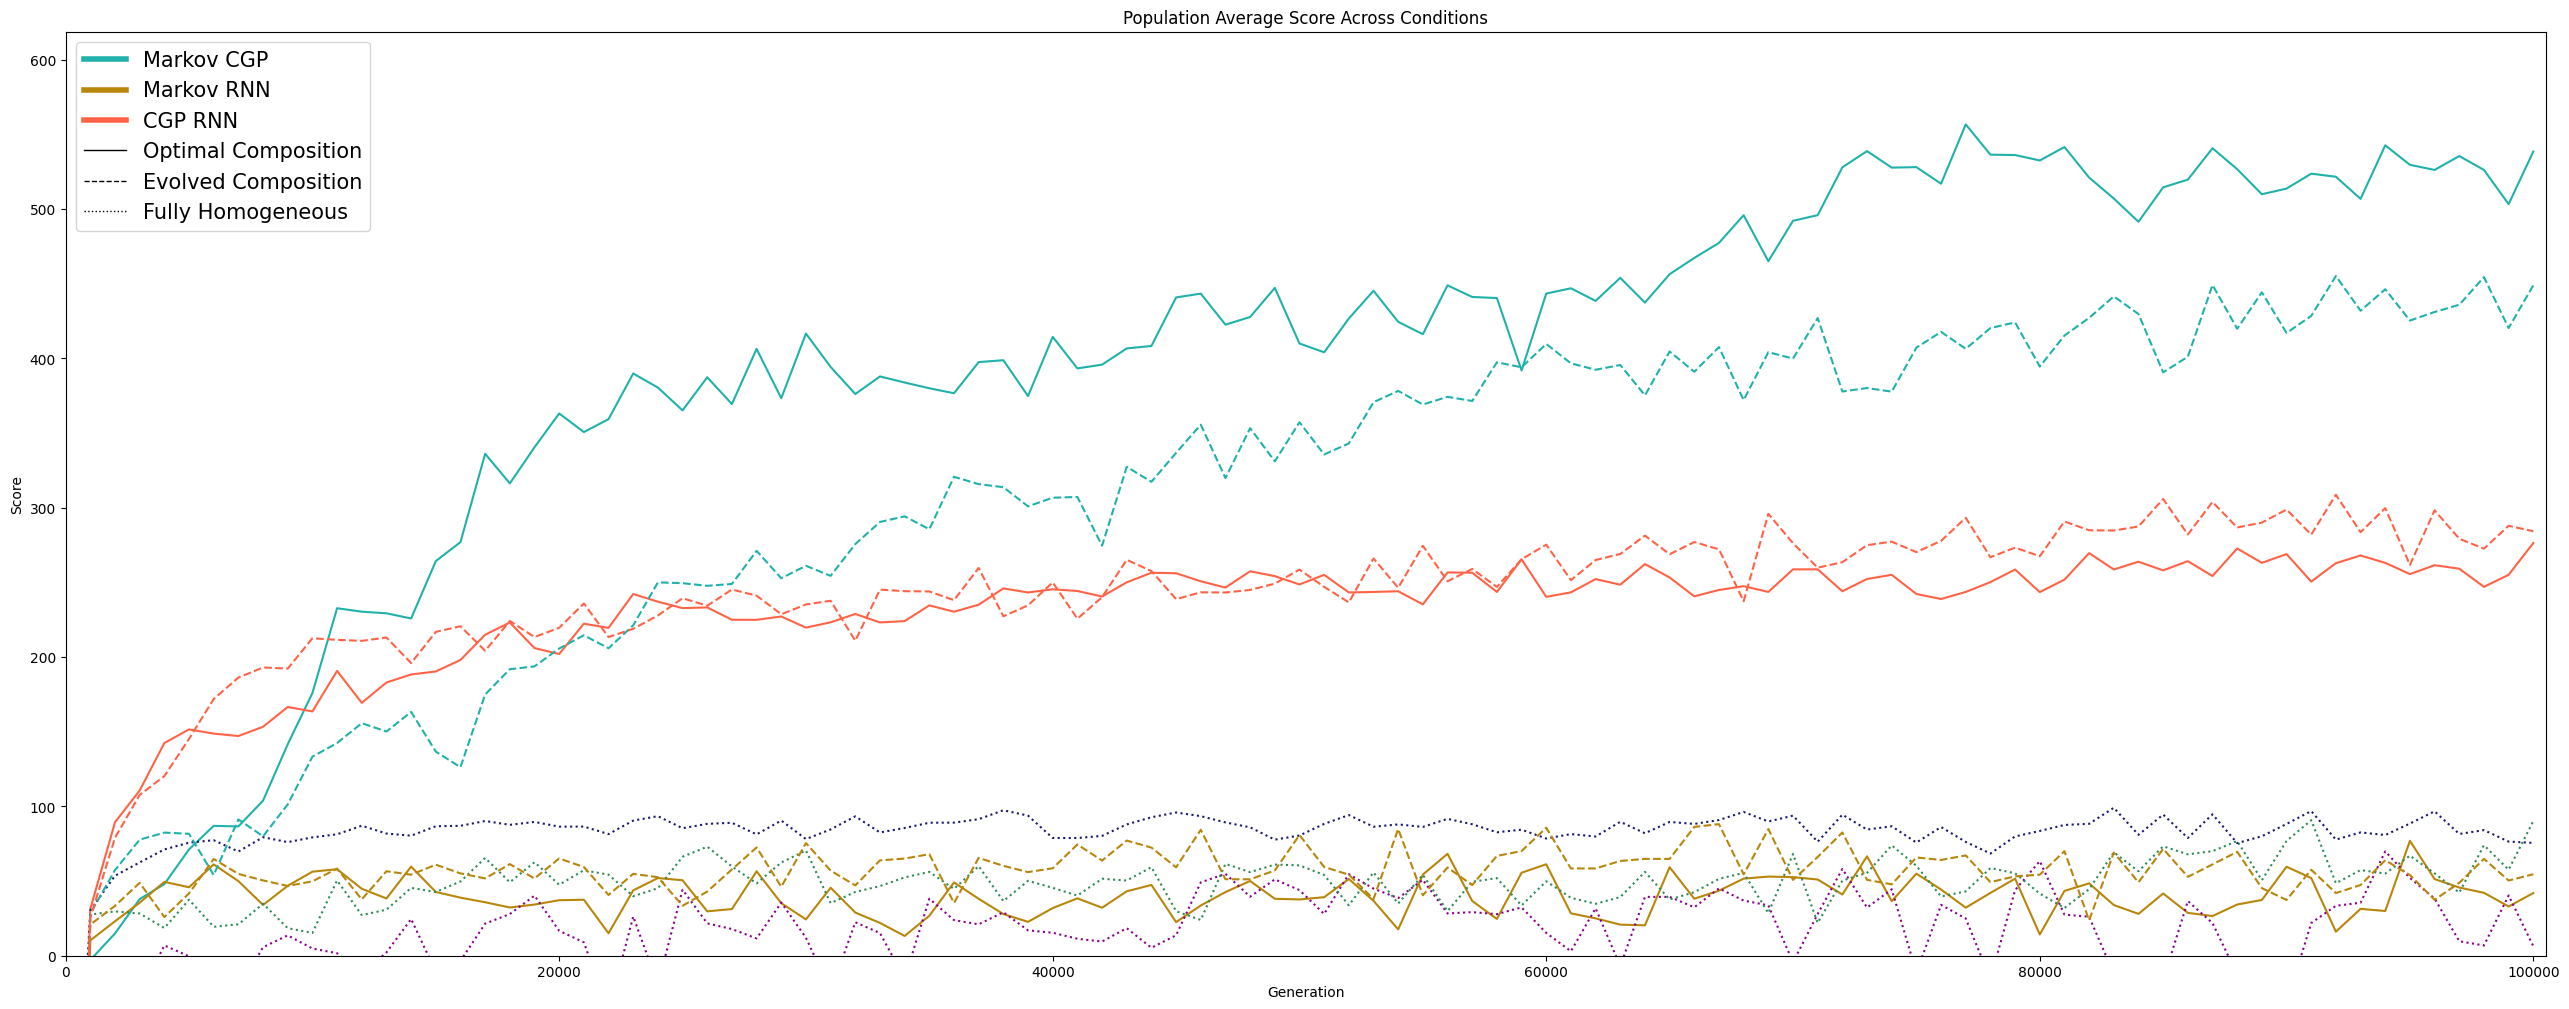

In [36]:
#Plot all scores for diff conditions
color_map = {
    'Markov CGP': 'lightseagreen',
    'Markov RNN': 'darkgoldenrod',
    'CGP RNN': 'tomato',
}
color_map2 = {
    'BRN_Markov': 'darkmagenta',
    'BRN_RNN': 'midnightblue',
    'BRN_CGP': 'seagreen',
}
line_styles = {
    'solid': {'linestyle': '-', 'label': 'Optimal Composition'},
    'dashed': {'linestyle': '--', 'label': 'Evolved Composition'},
    'dotted': {'linestyle': ':', 'label': 'Fully Homogeneous'}
}
plt.figure(figsize=(32,12))
for cond in scoresDirs:
    ls = '--' if "0.3" in cond[2] else '-'
    if "10" in cond[2]:
        ls = ":"
        for key in color_map2.keys():
            if all(word in cond[2] for word in key.split()):
                c = color_map2[key]
                break
    else:
        for key in color_map.keys():
            if all(word in cond[2] for word in key.split()):
                c = color_map[key]
                break
        else:
            color = 'black'  # Default color if no match is found    

    
    
    plt.plot(cond[0][::100], cond[1][::100], label=cond[2], linestyle=ls, color=c)

#colors legend
color_legend = [Line2D([0], [0], color=color_map[key], lw=4) for key in color_map]
color_labels = [key for key in color_map]

#line styles legend
style_legend = [Line2D([0], [0], color='black', linestyle=line_styles[key]['linestyle'], lw=1, markersize=20) for key in line_styles]
style_labels = [line_styles[key]['label'] for key in line_styles]

# Add legend to plot
plt.legend(handles=color_legend + style_legend, labels=color_labels + style_labels, loc='best', prop={'size': 15})

plt.ylim(bottom=0)
plt.xlim(right=100500)
plt.xlim(left=0)
plt.xlabel("Generation")
plt.ylabel("Score")
plt.title("Population Average Score Across Conditions")
plt.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

def helper(col):
    brain = col[:re.search(r'\D+', col).end()]
    brainID = col[re.search(r'\d', col).start()]
    match = match = re.search(r'\D*\d\D*(\d)', col)
    if match:
        resourceID = match.group(1)
    return brain, brainID, resourceID

# Function to plot select columns from a CSV file
def plot_reps(sub_dir):
    # Read CSV file into a DataFrame
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    rep_number = 0
    for dirpath, dirnames, filenames in os.walk(sub_dir):
        if "pop.csv" in filenames and "/001" not in dirpath:
            file_path = os.path.join(dirpath, "pop.csv")
            df = pd.read_csv(file_path)

            #score
            #axs[0, 0].plot(df['update'], df["score_AVE"], label=f'AVG Score rep{rep_number}') 
            sns.lineplot(data=df, x='update', y="score_AVE", ax=axs[0, 0], errorbar='sd')

        
            #comp
            axs[1, 1].plot(df['update'][::100], df["brain1Num_AVE"][::100])
        
            for col_name in df.keys():
                if "Attempted" in col_name:
                    brain, brainID, resourceID = helper(col_name)
                    if(True):
                    #we dont know brain2num and im annoyed
                    #if(int(brainID) == 1 and df["brain1Num_AVE"].iloc[-1] >= 3) or (int(brainID) == 2 and df["brain1Num_AVE"].iloc[-1] <= 5):
                        first, second = (0, 1) if int(brainID) == 1 else (1, 0)
                        axs[first, second].plot(df['update'][::100], (df[f"{brain}{brainID}_Resource{resourceID}_Completed_AVE"]/df[f"{brain}{brainID}_Resource{resourceID}_Attempted_AVE"])[::100] 
                                               )#label=f'{brain}{brainID} resource {resourceID} rep {rep_number}')
                        axs[first, second].set_title(brain)
                        axs[first, second].set_xlabel('Update')
                        axs[first, second].set_ylabel('Ratio')
                        #axs[first, second].legend()
        rep_number += 1

    axs[0, 0].set_title('Score')
    axs[0, 0].set_xlabel('Update')
    axs[0, 0].set_ylabel('Score')
    #axs[0, 0].legend()

    axs[1, 1].set_title('Comp')
    axs[1, 1].set_xlabel('Update')
    axs[1, 1].set_ylabel('Num Brain1')
    #axs[1, 1].legend()

    fig.suptitle(sub_dir)
    plt.tight_layout()
    plt.show()


subdirectories = [os.path.join(directory_path, d) for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
for replicate in subdirectories:
    plot_reps(replicate)


In [ ]:
#separate plots for all
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

def helper(col):
    brain = col[:re.search(r'\D+', col).end()]
    brainID = col[re.search(r'\d', col).start()]
    match = match = re.search(r'\D*\d\D*(\d)', col)
    if match:
        resourceID = match.group(1)
    return brain, brainID, resourceID

# Function to plot select columns from a CSV file
def plot_csv_file(csv_file):
    # Read CSV file into a DataFrame
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    df = pd.read_csv(csv_file)
    
    #score
    axs[0, 0].plot(df['update'], df["score_AVE"], label='AVG Score') 
    axs[0, 0].set_title('Score')
    axs[0, 0].set_xlabel('Update')
    axs[0, 0].set_ylabel('Score')
    axs[0, 0].legend()

    #comp
    axs[1, 1].plot(df['update'], df["brain1Num_AVE"], label='Num Markov')
    axs[1, 1].set_title('Comp')
    axs[1, 1].set_xlabel('Update')
    axs[1, 1].set_ylabel('Num Markov')
    axs[1, 1].legend()

    t = 0
    for col_name in df.keys():
        if "Attempted" in col_name:
            brain, brainID, resourceID = helper(col_name)
            first, second = (0, 1) if t > 1 else (1, 0)
            axs[first, second].plot(df['update'], df[f"{brain}{brainID}_Resource{resourceID}_Completed_AVE"]/df[f"{brain}{brainID}_Resource{resourceID}_Attempted_AVE"], 
                                    label=f'{brain}{brainID} resource {resourceID}')
            axs[first, second].set_title(brain)
            axs[first, second].set_xlabel('Update')
            axs[first, second].set_ylabel('Ratio')
            axs[first, second].legend()
            t += 1

    fig.suptitle(csv_file)
    plt.tight_layout()
    plt.show()

# Iterate over subdirectories and plot CSV files within them
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file == 'pop.csv' and "/001" not in dirs:
            csv_file_path = os.path.join(root, file)
            plot_csv_file(csv_file_path)
